# Step 0: Defining Model Class

In [25]:
# Basics
import pandas as pd
import numpy as np

#Plotting
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
plt.style.use('ggplot')

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Auto ARIMA
try:
    from pmdarima.arima import auto_arima
except:
    ! pip install pmdarima
    from pmdarima.arima import auto_arima

# Import statsmodels api
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Tools for saving the model
import pickle
from bz2 import BZ2File

# Mapping
import folium

class Model(object):
    
    def __init__(self, test_size=36, predict_size=24, start_date='2012-01-01'):
        self.model_dictionary = {}
        self.test_size = test_size
        self.predict_size = predict_size
        self.start_date = start_date
        
    def build_model(self):
        try:
            with BZ2File('modelArchive.bz2', 'rb') as file:
                self.model_dictionary = pickle.load(file)
        except:
            print("File not found. Building model.")
            zip_codes = self.model_dictionary.keys()
            N = len(zip_codes)
            for ind, zip_code in enumerate(zip_codes):
                self.fit(zip_code, trace=False)
                self.predict(zip_code)
                self.forecast(zip_code)
                self.compute_roi(zip_code)
                print(f'Finished processing {ind+1} out of {N} zip codes.')
            with BZ2File('modelArchive.bz2', 'wb') as file:
                pickle.dump(self.model_dictionary, file)
    
    # Load data from data frame
    def load_data(self, df):
        self._make_datetime_index(df)
        for ind in df.index.values:
            row = df.loc[ind]
            zip_code = self._get_zip_code(row)
            row_dict = self._make_row_dict(row)
            self.model_dictionary[zip_code] = row_dict
    
    def _make_datetime_index(self, df):
        string_index = df.columns.values[8:]
        self.datetime_index = pd.to_datetime(string_index)
            
    def _get_zip_code(self, row):
        return row['RegionName']
            
    def _make_row_dict(self, row):
        row_dict = row.iloc[1:8].to_dict()
        time_series = row.iloc[8:]
        df = self._make_time_series_df(time_series)
        df = df.fillna(df.bfill())
        row_dict['TimeSeries'] = df
        return row_dict
      
    def _make_time_series_df(self, time_series):
        time_series.index = self.datetime_index
        df = pd.DataFrame(time_series, dtype=float)
        df.columns = ['MedianSales']
        return df
    
    def get_time_series(self, zip_code):
        return self.model_dictionary[zip_code]['TimeSeries'][self.start_date:]
    
    def get_city_name(self, zip_code):
        return self.model_dictionary[zip_code]['City']
    
    def get_state_abbreviation(self, zip_code):
        return self.model_dictionary[zip_code]['State']
    
    # Train Test Split    
    def get_train_test_split(self, zip_code):
        time_series_df = self.get_time_series(zip_code)
        train = time_series_df[:-self.test_size]
        test = time_series_df[-self.test_size:]
        return train, test
    
    # Plotting
    def time_series_plot(self, zip_code, show_prediction=True, show_forecast=True):
        fig, ax = plt.subplots(figsize=(8, 5));
        self._time_series_plot_train_test_ax(zip_code, ax)
        legend_labels = ['Train', 'Test']
        if show_prediction:
            self._time_series_plot_prediction_ax(zip_code, ax)
            legend_labels.append('Prediction')
        if show_forecast:
            self._time_series_plot_forcast_ax(zip_code, ax)
            legend_labels.append('Forecast')
        self._time_series_plot_annotate(zip_code, ax, legend_labels)
        return fig
    
    def _time_series_plot_train_test_ax(self, zip_code, ax):
        train, test = self.get_train_test_split(zip_code)
        ax.plot(train);
        ax.plot(test);
        
    def _time_series_plot_prediction_ax(self, zip_code, ax):
        prediction = self.predict(zip_code)
        ax.plot(prediction['mean'])
        ax.fill_between(
            prediction.index,
            prediction['mean_ci_lower'],
            prediction['mean_ci_upper'],
            color = 'g',
            alpha = 0.5
        )
        
    def _time_series_plot_forcast_ax(self, zip_code, ax):
        forecast = self.forecast(zip_code)
        ax.plot(forecast['mean'])
        ax.fill_between(
            forecast.index,
            forecast['mean_ci_lower'],
            forecast['mean_ci_upper'],
            color = 'g',
            alpha = 0.5
        )
        
    def _time_series_plot_annotate(self, zip_code, ax, legend_labels):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        ax.set_title(f'Median Sale Price {city_name}, {state_abbreviation} {zip_code}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend(legend_labels);
        
    def acf_plot(self, zip_code):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        train, test = self.get_train_test_split(zip_code)
        fig, ax = plt.subplots(figsize=(8,5));
        plot_acf(
            x=train, 
            ax=ax, 
            lags=24,
            title=f'Autocorrelation for {city_name}, {state_abbreviation} {zip_code}'
        );
        return fig
    
    def pacf_plot(self, zip_code):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        train, test = self.get_train_test_split(zip_code)
        fig, ax = plt.subplots(figsize=(8,5));
        plot_pacf(
            x=train, 
            ax=ax, 
            lags=24,
            title=f'Partial Autocorrelation for {city_name}, {state_abbreviation} {zip_code}'
        );
        return fig
    
    # Model Selection
    def fit(self, zip_code, trace=True):
        try:
            best_model = self.model_dictionary[zip_code]['BestModel']
        except:
            y = self.get_time_series(zip_code)
            model = auto_arima(
                y = y,
                X=None,
                start_p=0,
                d=1,
                start_q=0,
                max_p=2,
                max_d=2,
                max_q=2,
                start_P=0,
                D=1,
                start_Q=0,
                max_P=2,
                max_D=2,
                max_Q=2,
                max_order=None,
                m=12,
                seasonal=True,
                stationary=False,
                information_criterion='oob',
                alpha=0.05,
                test='kpss',
                seasonal_test='OCSB',
                stepwise=True,            
                suppress_warnings=True,
                error_action='warn',
                trace=trace,
                out_of_sample_size= self.test_size,
                scoring='mse'
            )
            order = model.order
            seasonal_order = model.seasonal_order
            trend = model.trend
            best_model = SARIMAX(
                endog=y,
                order=order,
                seasonal_order=seasonal_order,
                trend='c'
            ).fit()
            self.model_dictionary[zip_code]['BestModel'] = best_model
        return best_model
    
    # Model Validation
    def predict(self, zip_code):
        try:
            prediction = self.model_dictionary[zip_code]['Prediction']
        except:
            model = self.fit(zip_code)
            prediction = model.get_prediction().summary_frame()
            self.model_dictionary[zip_code]['Prediction'] = prediction
        return prediction
    
    def plot_diagnostics(self, zip_code):
        best_model = self.fit(zip_code)
        city = self.get_city_name(zip_code)
        state = self.get_state_abbreviation(zip_code)
        fig = best_model.plot_diagnostics(figsize=(16, 10));
        fig.suptitle(f'Diagnostics for {city}, {state} {zip_code}', fontsize=16)
        return fig
    
    # Predict future prices
    def forecast(self, zip_code):
        try:
            forecast = self.model_dictionary[zip_code]['Forecast']
        except:
            model = self.fit(zip_code)
            forecast = model.get_forecast(steps=self.predict_size).summary_frame()
            self.model_dictionary[zip_code]['Forecast'] = forecast
        return forecast
    
    # Compute ROI
    def compute_roi(self, zip_code):
        try:
            roi = self.model_dictionary[zip_code]['ROI']
        except:
            initial_price = self.get_time_series(zip_code)['MedianSales'][-1]
            final_price = self.forecast(zip_code)['mean'][-1]
            roi = (final_price-initial_price)/initial_price
            self.model_dictionary[zip_code]['ROI'] = roi
        return roi
    
    # Select top 5 zip codes by ROI
    def roi_df(self):
        roi_dict = {
            'zip_code': [],
            'ROI': []
        }
        for zip_code in self.model_dictionary.keys():
            roi_dict['zip_code'].append(zip_code)
            roi_dict['ROI'].append(self.model_dictionary[zip_code]['ROI'])
        roi_df = pd.DataFrame(roi_dict)
        roi_df['zip_code'] = roi_df['zip_code'].astype(str)
        return roi_df
    
    def zip_code_map(self):
        
        geojason_url = 'https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/md_maryland_zip_codes_geo.min.json'
        zip_code_map = folium.Map(location=[39.29, -76.61], width=800, height=600, zoom_start=12)
        folium.Choropleth(
            geo_data=geojason_url,
            name='choropleth',
            data=self.roi_df(),
            columns=['zip_code','ROI'],
            key_on='feature.properties.ZCTA5CE10',
            fill_color='RdPu',
            fill_opacity=0.7,
            nan_fill_opacity=0
        ).add_to(zip_code_map)
        return zip_code_map

# Step 1: Import the Data
Our main data set is stored in the `zillow_data.csv` spreadsheet. We load the CSV file as a data frame below.

In [3]:
df = pd.read_csv('../data/ZHVI.csv.gz', index_col='RegionID', compression='gzip')
print(df.shape)
df.head()

(30205, 306)


,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,...,930560.0,932099.0,933253.0,930160.0,926279.0,920531.0,919481.0,920766.0,927266.0,932302.0
84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,296113.0,295520.0,...,786707.0,787854.0,789482.0,790451.0,790939.0,791300.0,793322.0,796143.0,801148.0,806603.0
61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,...,1290836.0,1291613.0,1288723.0,1283261.0,1278518.0,1279537.0,1279105.0,1280177.0,1282240.0,1289935.0
91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,203140.0,203391.0,...,340112.0,340320.0,340828.0,341998.0,343077.0,343858.0,344397.0,345495.0,346575.0,348416.0
84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,462086.0,461720.0,...,1010879.0,1012589.0,1014209.0,1015467.0,1015662.0,1017251.0,1020360.0,1023859.0,1029882.0,1036427.0


We will restrict our attention to the city of Baltimore, so we filter the data below.

In [4]:
df = df.query("City == 'Baltimore' and State == 'MD'")
print(df.shape)
df.head()

(20, 306)


,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
RegionID,,,,,,,,,,,,,,,,,,,,,
66825,368,21215,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,80880.0,80666.0,...,141847.0,142485.0,142719.0,143417.0,143771.0,143966.0,144283.0,145614.0,147702.0,150608.0
66834,484,21224,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,93965.0,93858.0,...,181401.0,181205.0,181259.0,181296.0,181779.0,182020.0,182601.0,183819.0,186429.0,189625.0
66828,744,21218,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,71417.0,71853.0,...,158316.0,158647.0,159052.0,159753.0,160528.0,160478.0,160820.0,161670.0,164124.0,166767.0
66816,783,21206,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,82607.0,82660.0,...,157113.0,156408.0,155997.0,155919.0,156004.0,155849.0,156458.0,158033.0,160752.0,163549.0
66839,1088,21229,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,82654.0,82794.0,...,120521.0,121307.0,121899.0,122483.0,123296.0,124109.0,125143.0,126557.0,129136.0,131301.0


# Step 2: Instantiate the Model and Load in the Data
Below we instantiate a Model object and load our selected data into the object.

In [5]:
model = Model()
model.load_data(df)

# Step 3: EDA and Visualization
Below we display a time series plot, ACF plot, and PACF plot for the zip code 21215. The class methods used below will work for any zip code in our model.

In [58]:
zip_code = 21213

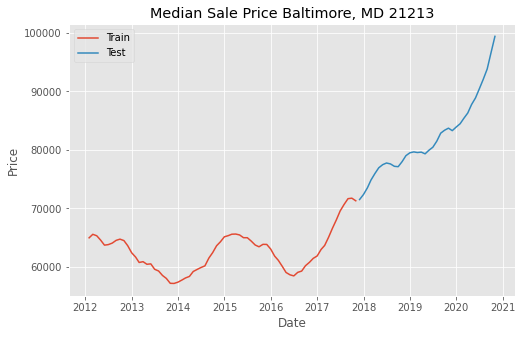

In [59]:
model.time_series_plot(zip_code, show_prediction=False, show_forecast=False);

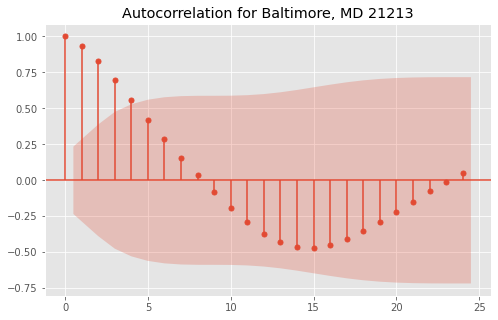

In [60]:
model.acf_plot(zip_code);

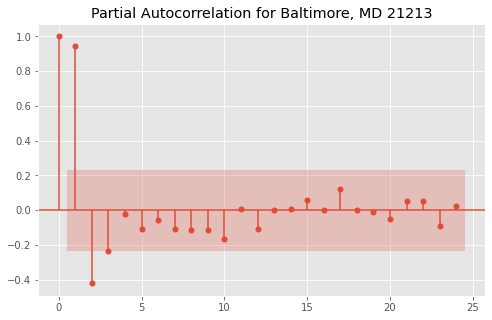

In [61]:
model.pacf_plot(zip_code);

# Step 4: ARIMA Modeling
Below we select the best ARIMA model for our example zip code.

In [62]:
best_model = model.fit(zip_code)

# Step 5: Model Validation
Below we make an in sample prediction using our best model, display the prediction with the actual data, and display diagnostic plots for the fit.

In [63]:
model.predict(zip_code)

MedianSales,mean,mean_se,mean_ci_lower,mean_ci_upper
2012-01-31,0.000000,1657.060581,-3247.779058,3247.779058
2012-02-29,67804.222700,1319.330159,65218.383105,70390.062295
2012-03-31,66542.554286,1317.985241,63959.350681,69125.757892
2012-04-30,65185.937314,1317.858572,62602.981977,67768.892651
2012-05-31,64525.480039,1317.855765,61942.530203,67108.429876
...,...,...,...,...
2020-06-30,89546.731413,845.806691,87888.980760,91204.482067
2020-07-31,91548.624365,845.806691,89890.873712,93206.375018
2020-08-31,93445.481989,845.806691,91787.731336,95103.232642
2020-09-30,94370.713752,845.806691,92712.963099,96028.464405


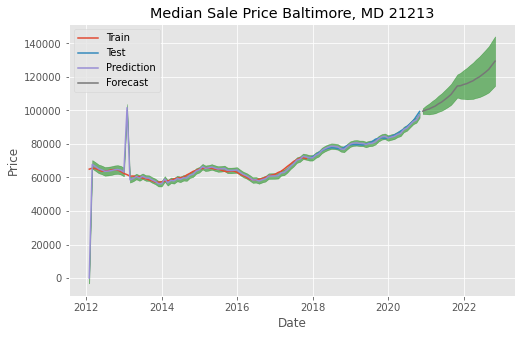

In [64]:
fig = model.time_series_plot(zip_code);


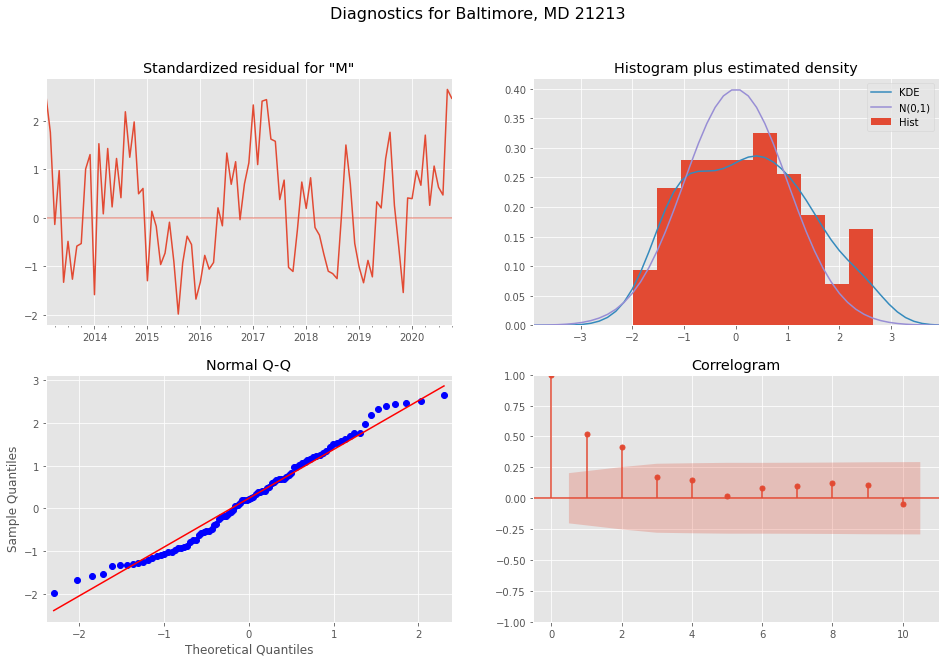

In [65]:
model.plot_diagnostics(zip_code);

# Step 6: Making a Forecast
Below we forecast into the future, make a final time series plot which includes our forecast, and compute our expected return on investment for the example zip code.

In [66]:
model.forecast(zip_code)

MedianSales,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-11-30,99592.638328,845.806691,97934.887674,101250.388981
2020-12-31,100348.045273,1292.127209,97815.522479,102880.568067
2021-01-31,100907.362757,1653.662191,97666.244419,104148.481095
2021-02-28,101769.038373,1949.257438,97948.563997,105589.512748
2021-03-31,102625.967207,2205.586198,98303.097693,106948.836720
2021-04-30,103932.929280,2435.080367,99160.259461,108705.599100
2021-05-31,105000.879044,2644.734829,99817.294031,110184.464056
2021-06-30,106421.757754,2838.948438,100857.521063,111985.994446
2021-07-31,107936.135486,3020.700937,102015.670442,113856.600530
2021-08-31,109579.931456,3192.121562,103323.488160,115836.374752


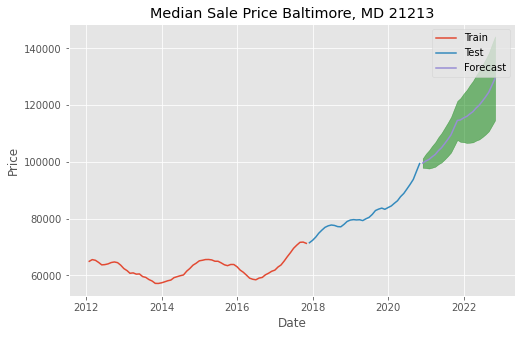

In [67]:
fig = model.time_series_plot(zip_code, show_prediction=False);
fig.savefig('../images/best_zip.png', dpi=600)

In [39]:
model.compute_roi(zip_code)

0.30216303460746746

# Step 7: Building the Model

In [18]:
try:
    model.build_model()
except:
    model = Model()
    model.build_model()

# Step 8: Picking Top Five Zip Codes

In [19]:
roi_df = model.roi_df()

In [41]:
top_five = roi_df.sort_values(by='ROI', ascending=False).iloc[:5]
top_five

,zip_code,ROI
10,21213,0.302163
4,21229,0.195755
11,21216,0.190483
7,21239,0.159679
19,21226,0.135404


# Step 9: Map Zip Codes

In [21]:
zip_code_map = model.zip_code_map()

In [22]:
import io
from PIL import Image

img_data = zip_code_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('../images/zip_code_map.png')